# Background Correction Notebook

<div class="custom-button-row">
    <a 
        class="custom-button custom-download-button" href="../../notebooks/07_measurement_and_quantification/background_correction_notebook.ipynb" download>
        <i class="fas fa-download"></i> Download this Notebook
    </a>
    <a
    class="custom-button custom-download-button" href="https://colab.research.google.com/github/HMS-IAC/bobiac/blob/gh-pages/colab_notebooks/07_measurement_and_quantification/background_correction_notebook.ipynb" target="_blank">
        <img class="button-icon" src="../../_static/logo/icon-google-colab.svg" alt="Open in Colab">
        Open in Colab
    </a>
</div>

In [ ]:
# /// script
# requires-python = ">=3.10"
# dependencies = [
#     "matplotlib",
#     "ndv[jupyter,vispy]",
#     "numpy",
#     "scikit-image",
#     "scipy",
#     "tifffile",
#     "imagecodecs",
# ]
# ///

## Overview

In this notebook, we will explore different approaches to **background correction** in fluorescence microscopy images. Background correction is a crucial pre-processing step that helps remove unwanted background signal and improves the quality of quantitative analysis. We will use the [**scikit-image**](https://scikit-image.org/docs/stable/) library to perform the background correction. Background subtraction is useful when the background is uniform and the signal to noise ratio is high.

We will demonstrate a simple background subtraction method using a sample fluorescence image. The main approaches we'll cover are:

- Subtracting a constant background value (e.g. mode or median of the image)
- Selecting and averaging background regions to determine background level

The choice of method depends on your specific imaging conditions and the nature of the background in your images. Here we'll demonstrate a basic approach that works well for images with relatively uniform background and distinct fluorescent signals.

<p class="alert alert-info">
    <strong>Note:</strong> Background correction should be done on raw images before any other processing steps. The corrected images can then be used for further analysis like segmentation and quantification.
</p>

The images we will use for this section can be downloaded from the <a href="../../../_static/data/07_measurement_and_quantification.zip" download> <i class="fas fa-download"></i> Measurement and Quantification Dataset</a>.

## Importing libraries

In [9]:
import matplotlib.pyplot as plt
import ndv
import numpy as np
import scipy
import skimage
import tifffile

## Background subtraction: mode subtraction 

Background subtraction can be done in different ways. If the background dominates the image as in the example we will use, the most common pixel value (the **mode value**) can serve as a rough background estimate and we can subtract this value from the image.

Let's first load, display with `ndv` and explore the pixel values of the `07_bg_corr_nuclei.tif` image.

In [16]:
# raw image and labeled mask
image = tifffile.imread("../../_static/images/quant/07_bg_corr_nuclei.tif")

In [ ]:
ndv.imshow(image)

In [ ]:
viewer = ndv.imshow(image)

In [ ]:
viewer.widget().children[1].snapshot()

As you can notice, most of the pixel in the image belong to the background (anything but the nuclei). Therefore we can try to use the **mode value** of the image as a background estimate. We can use the `scipy.stats.mode` function to compute the mode of the image. 

In [17]:
# Flatten image and get the mode
mode_val = scipy.stats.mode(image.ravel(), keepdims=False).mode
print(f"Estimated background (mode): {mode_val:.3f}")

Estimated background (mode): 33055.000


Then, we can subtract the **mode value** from the image and print the minimum and maximum pixel values of the resulting image.

<p class="alert alert-info">
    <strong>Important:</strong> Before performing subtraction, convert the image to a <strong>floating-point</strong> (e.g., <code>image.astype(np.float32)</code>. This prevents <strong>unsigned integer underflow</strong>, which occurs when subtracting the mode value from pixels with intensities lower than the mode. In unsigned integer formats (like <code>uint16</code>), negative results wrap around to very large positive values (e.g., -1 becomes 65535), leading to incorrect results.
</p>

In [39]:
# Subtract mode from the image (after converting to float32)
image_mode_sub = image.astype(np.float32) - mode_val
print(f"Min: {image_mode_sub.min():.2f}, Max: {image_mode_sub.max():.2f}")

Min: -71.00, Max: 3808.00


As you can see there are some negative values in the resulting image. This is because some pixels in the original image had values lower than the mode value, and when we subtract the mode from these pixels, we get negative values.

To keep working with the image, we need to handle these negative values. One common approach is to clip the negative values to zero, effectively setting any negative pixel values to zero. This is appropriate since we want background-corrected intensities to be greater than or equal to zero.

For that, we can use the `numpy` `np.clip` function to set any negative values to zero and then print the minimum and maximum pixel values of the resulting image.

In [42]:
image_mode_sub_to_zero = np.clip(image_mode_sub, 0, None)
print(
    f"Min: {image_mode_sub_to_zero.min():.2f}, Max: {image_mode_sub_to_zero.max():.2f}"
)

Min: 0.00, Max: 3808.00


Finally, we can visualize the background-corrected image (either with `matplotlib` or `ndv`):

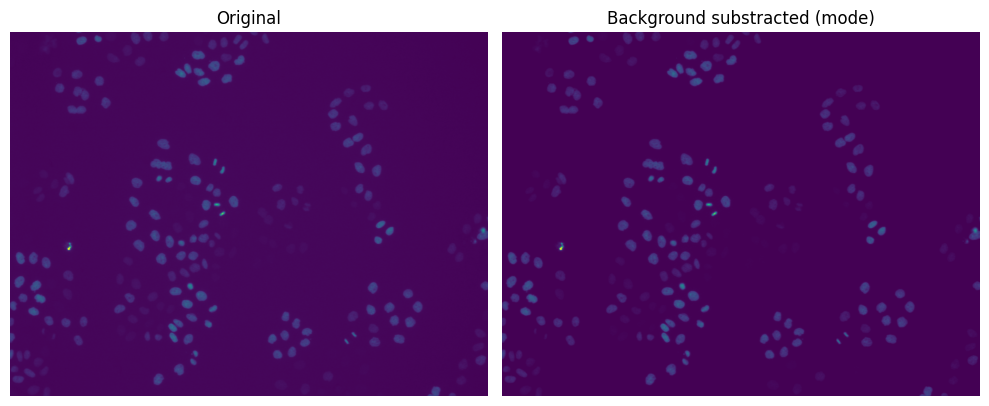

In [44]:
plt.figure(figsize=(10, 8))
plt.subplot(121)
plt.imshow(image)
plt.title("Original")
plt.axis("off")

plt.subplot(122)
plt.imshow(image_mode_sub_to_zero)
plt.title("Background subtracted (mode)")
plt.axis("off")

plt.tight_layout()
plt.show()

## Background subtraction: selected regions

Sometimes the background isn't uniform, or the mode isn't representative. In these cases, we can manually choose a region we believe contains only background and estimate the average intensity in that region.

First, we select a region of the image that we believe contains only background, and we compute the average intensity in that region:

In [ ]:
# Choose a top-left corner patch assumed to be background
bg_patch = image[0:150, 0:150]
bg_mean = np.mean(bg_patch)
print(f"Estimated background (mean of selected region): {bg_mean:.3f}")

Estimated background (mean of selected region): 25.705


As we did before, we can subtract this value from the image, and clip the result to be between 0 and 1:

In [ ]:
image_bgmean_sub = image - bg_mean

And visualize the result:

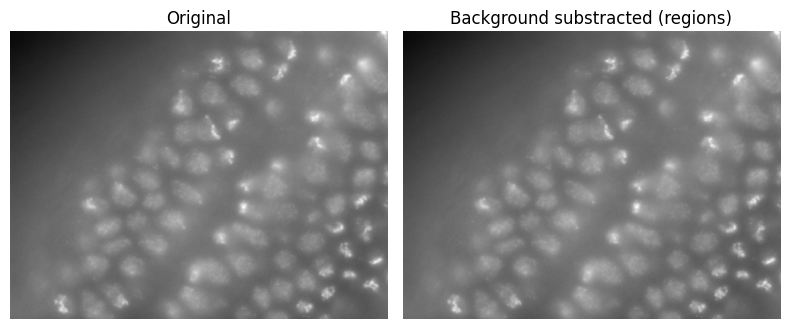

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(121)
plt.imshow(image)
plt.title("Original")
plt.axis("off")

plt.subplot(122)
plt.imshow(image_bgmean_sub)
plt.title("Background subtracted (regions)")
plt.axis("off")

plt.tight_layout()
plt.show()

## Background subtraction: rolling ball algorithm

The rolling ball algorithm is a method for background subtraction that uses a [rolling ball](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_rolling_ball.html) to estimate the background. It is a good method for background subtraction when the background is not uniform. The radius parameter configures how distant pixels should be taken into account for determining the background intensity.

Let's first load another image of a Drosophila embryo that has a non-uniform background:

In [ ]:
# raw image
image = tifffile.imread("../../_static/images/quant/07_bg_corr_WF_drosophila.tif")

Therefore, we can estimate the background by using the rolling ball algorithm:

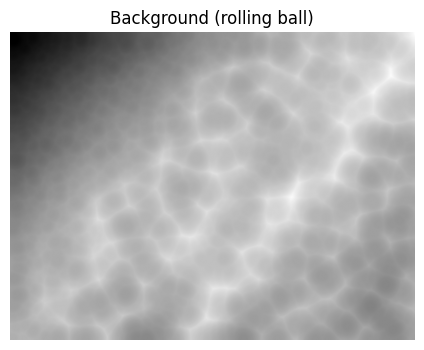

In [10]:
background_residue = skimage.restoration.rolling_ball(image, radius=100)

plt.figure(figsize=(8, 4))
plt.imshow(background_residue, cmap="gray")
plt.title("Background (rolling ball)")
plt.axis("off")
plt.show()

Afterwards, we subtract the background residue from the image:

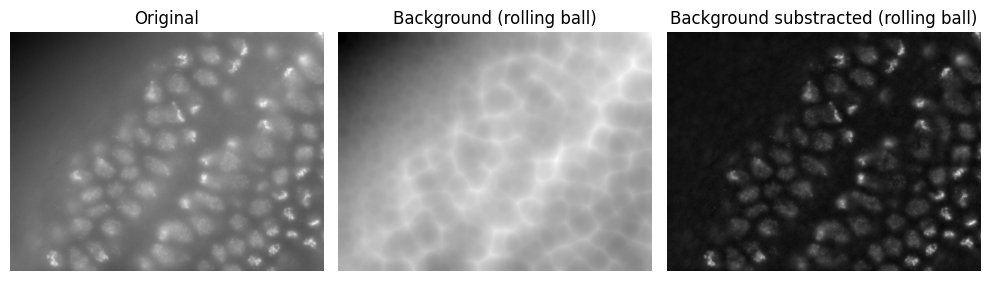

In [11]:
image_rb_sub = image - background_residue

plt.figure(figsize=(10, 10))

plt.subplot(131)
plt.imshow(image, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(132)
plt.imshow(background_residue, cmap="gray")
plt.title("Background (rolling ball)")
plt.axis("off")

plt.subplot(133)
plt.imshow(image_rb_sub, cmap="gray")
plt.title("Background subtracted (rolling ball)")
plt.axis("off")

plt.tight_layout()
plt.show()

## Other Background Subtraction Techniques

These are more advanced or specialized techniques you can explore:

- **Morphological opening**: Removes small foreground objects to approximate the background.
- **Gaussian/median filtering**: Smooths out the image to isolate large-scale variations.
- **Polynomial surface fitting**: Useful when background varies gradually across the field.
- **Tiled/local background subtraction**: Estimate and subtract background patch-by-patch.

Your method choice should depend on image modality, signal-to-noise, and application.

A good reference for background correction is the [scikit-image documentation](https://scikit-image.org/docs/0.25.x/api/skimage.restoration.html).
